In [14]:
import glob
import re
import cv2
import numpy as np
import os
import torchvision.transforms as T
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from ipywidgets import interact, FloatSlider
%matplotlib inline

In [15]:
def make_models(model_paths):
        
    class DeepAutoencoder(nn.Module):
        def __init__(self):
            super(DeepAutoencoder, self).__init__()
            self.Encoder = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 256 -> 128
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 128 -> 64
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 64 -> 32
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 32 -> 16
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 16 -> 8
            )
            self.Decoder = nn.Sequential(
                nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 8 -> 16
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 16 -> 32
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # 32 -> 64
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 64 -> 128
                nn.ReLU(),
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),  # 128 -> 256
                nn.ReLU(),
                nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            )

        def forward(self, x):
            x = self.Encoder(x)
            # x = self.Decoder(x)
            return x
    
    models = []
    for model_path in model_paths:
        model = DeepAutoencoder().cuda()
        model.load_state_dict(torch.load(model_path))
        models.append(model)
    return models

In [16]:
def AE(IMGS, models):
    preprocess = T.Compose([T.ToTensor()])
    n = len(models)

    # スコアリストの初期化
    score_lists = [[] for _ in range(n)]
    
    for IMG in IMGS:
        for index, model in enumerate(models):
            model.eval()
            img = preprocess(IMG).unsqueeze(0).cuda()
            with torch.no_grad():
                output = model(img)[0]
            # outputの0番目と2番目の次元を入れ替える
            output = output.cpu().numpy().transpose(1, 2, 0)
            score_lists[index].append(output)
    
    return score_lists

In [17]:
def get_image_filenames(directory):
    # 画像ファイルのリストを取得
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # 数値部分を考慮してソートするためのキー関数
    def alphanum_key(s):
        return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]
    
    # ファイル名を数値部分を考慮してソート
    image_files.sort(key=alphanum_key)
    return image_files

def load_images(directory):
    # ファイル名を取得してソート
    image_filenames = get_image_filenames(directory)
    
    # 画像を読み込んでリストに格納
    images = [cv2.imread(os.path.join(directory, filename)) for filename in image_filenames]
    return images, image_filenames

def find_label_switch_indices(filenames):
    labels = [filename.split('_')[0] for filename in filenames]
    switch_indices = []
    
    for i in range(1, len(labels)):
        if labels[i] != labels[i - 1]:
            switch_indices.append(i)
    
    return switch_indices

def pca_n(score_lists,n):
    pca_score_lists = []
    for i in range(len(score_lists)):
        flattened_data = [data.flatten() for data in score_lists[i]]
        flattened_data = np.array(flattened_data)
        pca = PCA(n_components=n)
        pca_score = pca.fit_transform(flattened_data)
        pca_score_lists.append(pca_score)
    return pca_score_lists  

def pca_check(score_lists):
    for i in range(len(score_lists)):
        flattened_data = [data.flatten() for data in score_lists[i]]
        flattened_data = np.array(flattened_data)
        pca = PCA(n_components=30)
        pca.fit(flattened_data)
        plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_)

def plt_pca2(pca_score_lists,labels):
    pca_result = pca_score_lists[0]
    x = pca_result[:, 0]
    y = pca_result[:, 1]

    # ラベルをエンコード
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    unique_labels = label_encoder.classes_

    plt.figure(figsize=(10, 10))
    for label in unique_labels:
        idx = encoded_labels == label_encoder.transform([label])[0]
        plt.scatter(x[idx], y[idx], label=label)
    
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA Result')
    plt.legend()
    plt.show()

In [18]:
def pca2_kmeans(pca_score_lists2):
    pca_result = pca_score_lists2[0]
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(pca_result)
    cluster_assignments = kmeans.labels_

    # クラスタの中心を取得
    cluster_centers = kmeans.cluster_centers_

    # クラスタの中心をx座標でソートし、新しいクラスタ番号を割り当て
    sorted_indices = np.argsort(cluster_centers[:, 0])
    new_labels = np.zeros_like(cluster_assignments)
    for new_label, old_label in enumerate(sorted_indices):
        new_labels[cluster_assignments == old_label] = new_label

    # 新しいクラスタ番号でプロット
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.scatter(pca_result[new_labels == i, 0], 
                    pca_result[new_labels == i, 1], 
                    label=f'Cluster {i}')
    plt.legend()
    plt.title('PCA Results with KMeans Clustering')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

In [ ]:
# ここからメイン
files_path = "imgs/make_pca_img1000"
images, image_filenames = load_images(files_path)

# モデルのパス
model_paths = ["models/for_make_model/6048_AEdeepmodel_20241217_A_train_img.pth"]
# モデルの読み込み
models = make_models(model_paths)

score_lists=AE(images,models)

# ラベルの切り替わりのインデックスを検出
switch_indices = find_label_switch_indices(image_filenames)

# ラベルを抽出
labels = [filename.split('_')[0] for filename in image_filenames]

/tmp/ipykernel_5465/3660162401.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


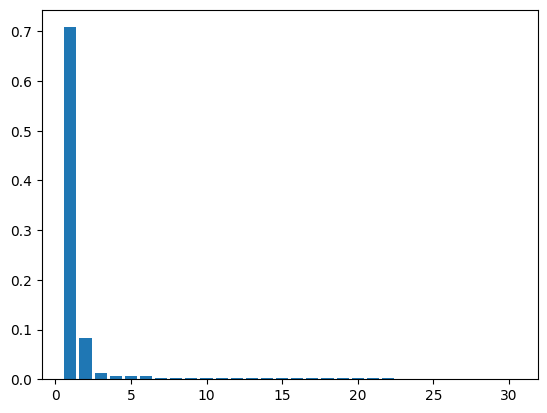

In [20]:
pca_check(score_lists)

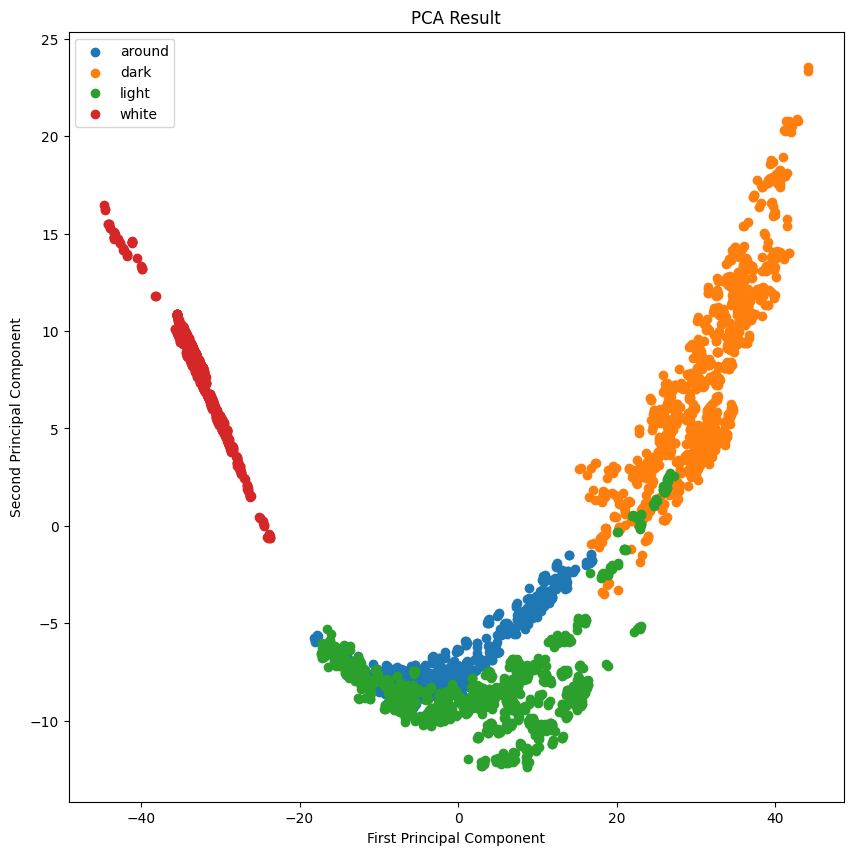

In [21]:
# PCAを適用
pca_score_lists2 = pca_n(score_lists,2)

# ラベルごとに色分けしてプロット
plt_pca2(pca_score_lists2,labels)

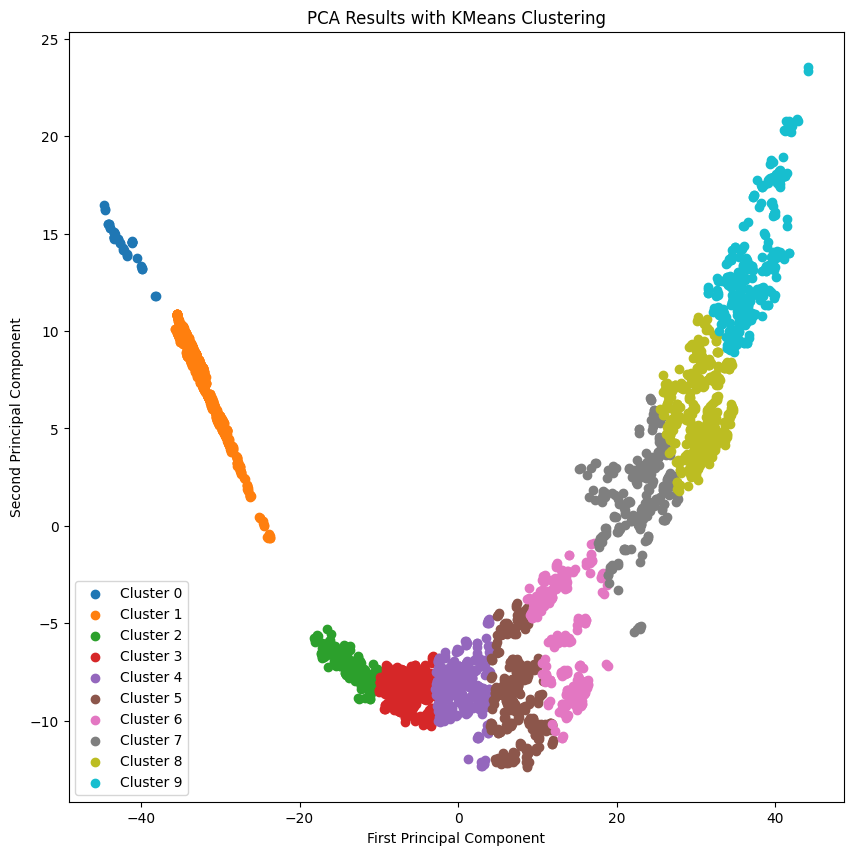

In [22]:
pca2_kmeans(pca_score_lists2)